## Two Region Fourier Transform

Suppose we have two material regions and want to do the Fourier Transform of an input function on each one.  At the same time, the underlying wave solutions on each region have to meet smoothly at the interface.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from slab import SlabExact
%matplotlib widget
plt.style.use('dark_background')

In [2]:
A = SlabExact(ts=[3e-6, 3e-6], ns=[1., 2], wl=2*np.pi*1e-6, xrefs=[500, 500], symmetric=True)

NameError: name 'SlabExact' is not defined

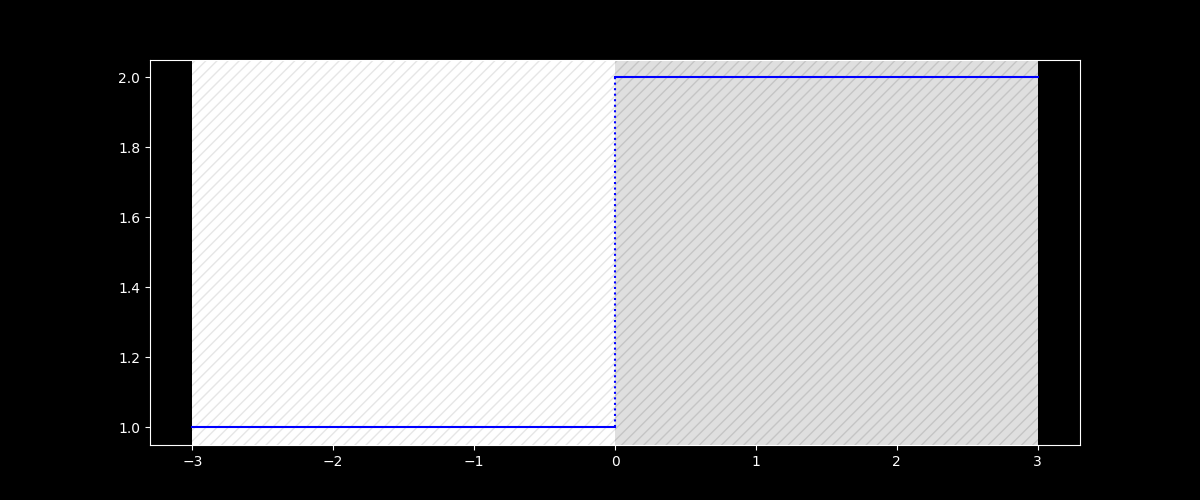

In [3]:
A.plot_refractive_index(plot_regions=True)

Say we have an input function of the following form:

In [1]:
def modified_(x):
    return (x-1/4) * np.exp(-(x-1/2)**2)  

def f_input_2(x):
    return np.exp(-x**2) 

def quadratic_piecewise(x):
    conds = [(x<-.5), ((-.5<=x)*(x<=.5)), (x>.5)]
    funcs = [0, lambda x: .25-x**2, 0]
    return np.piecewise(x, conds, funcs)
    
all_xs = A.all_Xs
xLs, XRs = A.Xs[:]

NameError: name 'A' is not defined

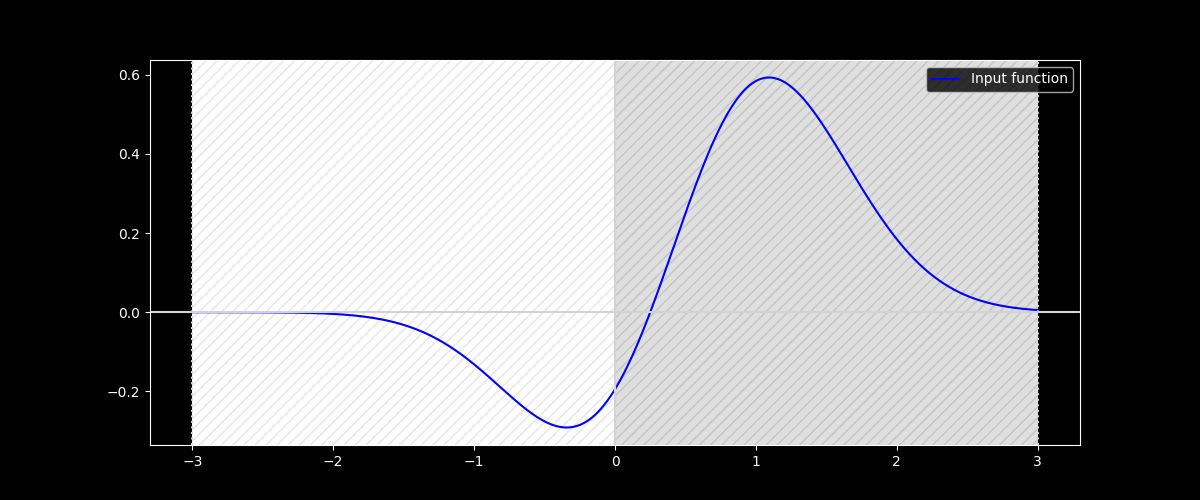

In [5]:
A.plot_field_1d(f_input_1, plot_regions=True, label='Input function', color='b')
plt.legend();


###  Expansion

Each region represents a different material.  In this case, the material on the right has a higher refractive index, so waves in this material have shorter wavelengths than the material in the left.  In particular, the refractive index of the left material is 1 and the right material is 1.4.  The input wavelength is chosen to be $2\pi$ microns, and the scaling is 1 micron, so the free space wavenumber $k_0$ is 1.  This then gives the material wavenumber in each region being the same as the refractive index.

The fields in each region need to satisfy

$$ u'' = -Z_i^2 u$$

where $Z_i$ depends on the region and $Z_2 = \sqrt{k_2^2 - k_1^2 + Z_1^2} = \sqrt{n_2^2 - n_1^2 + Z_1^2}$ (since $k_0 =1$ with this scaling and wavelength).

Our field on region 1 $(x<0=\rho)$ is given by

$$ F_1(x, Z_1) = A_1(Z_1) e^{iZ_1 x} + \bar{A}_1(Z_1) e^{-iZ_1x}$$

while on region 2 $(x>0=\rho)$ it is

$$ F_2(x, Z_2) = A_2(Z_2) e^{iZ_2 x} + \bar{A}_2(Z_2) e^{-iZ_2x}.$$

The need for conjugate coefficients arises from the need for standing wave solutions for the Fourier Expansion (more will be said here later, but for now just know we need this).

For TE modes, we will require that these solutions meet smoothly at the interface $\rho=0$ (TM have different requirements, to be dealt with later).  But to begin, lets just do the Fourier expansion on each region and see what we get.


### Typical Piecewise Field Solution

In [6]:
Frad = A.fields(0, mode_type='radiation')

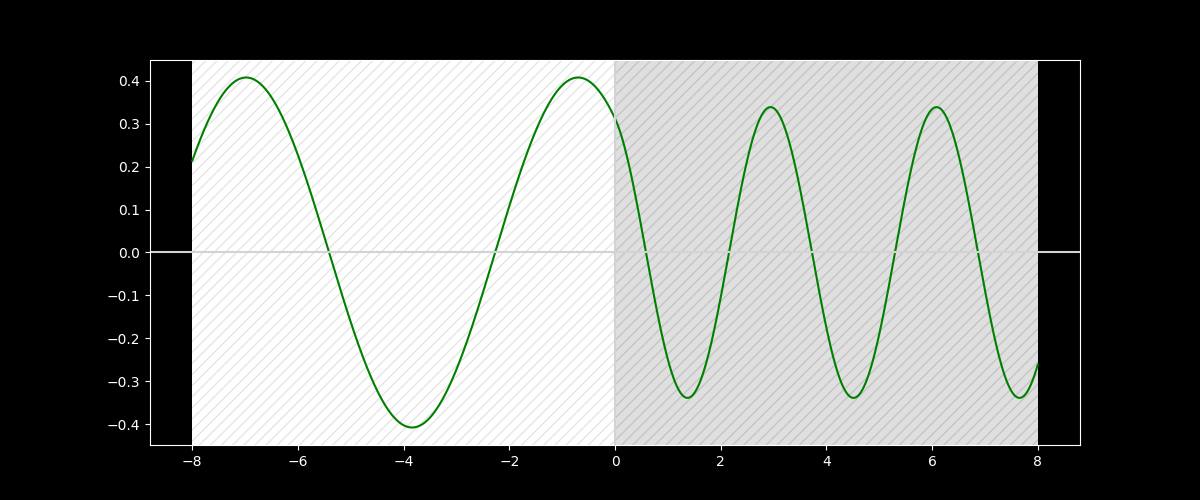

In [7]:
A.plot_field_1d(Frad, xs=np.linspace(-8, 8, 2000), plot_regions=True, plot_Rhos=False, color='g')

## Define transform

Need $$F(Z_1) = \frac{1}{2\pi}\int_{x=-\infty}^{\infty} f(x) e^{iZ_1 x} dx$$

In [36]:
def Fsci1(Z1, f=f_input_1):
    return 1/(2*np.pi)*quad(lambda x: f(x)*np.exp(1j*Z1*x), -np.inf, np.inf, complex_func=True)[0]


def F1(Z1, f=f_input_1, Lx=-3, Rx=3, N=11):
    xs = np.linspace(Lx, Rx, N)
    dx = xs[1] - xs[0]
    return 1/(2*np.pi)*sum([f(x)*np.exp(1j*Z1*x)*dx for x in xs])
    

F1 = np.vectorize(F1)
Fsci1 = np.vectorize(Fsci1)

In [55]:
all_Zs = np.linspace(-5,5, 100)
F1ws = F1(all_Zs)
Fsci1s = Fsci1(all_Zs)

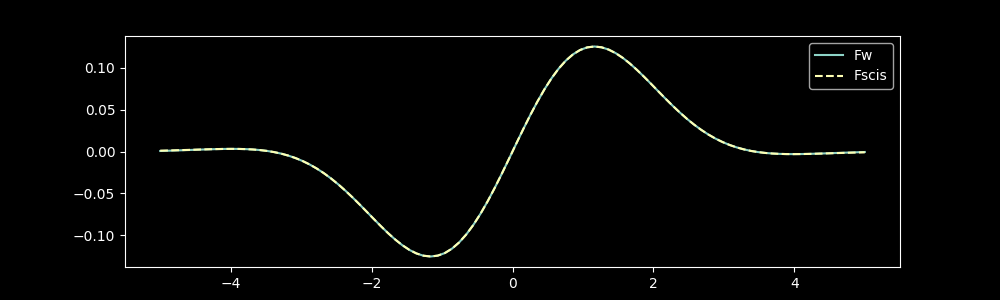

In [56]:
plt.close('all')
fig, ax = plt.subplots(figsize=(10,3))
ax.plot(all_Zs, F1ws.imag, label='Fw')
ax.plot(all_Zs, Fsci1s.imag, '--', label='Fscis')
plt.legend();


In [66]:
def f1(x, F=F1, LZ1=-5, RZ1=5, NZ1=12, Lx=-3, Rx=3, Nx=11):
    Z1s = np.linspace(LZ1, RZ1, NZ1)
    dZ1 = Z1s[1] - Z1s[0]
    return sum([F(Z1, Lx=Lx, Rx=Rx, N=Nx)*np.exp(-1j*Z1*x)*dZ1 for Z1 in Z1s])
    
f1 = np.vectorize(f1)

In [67]:
f1s = f1(xLs)

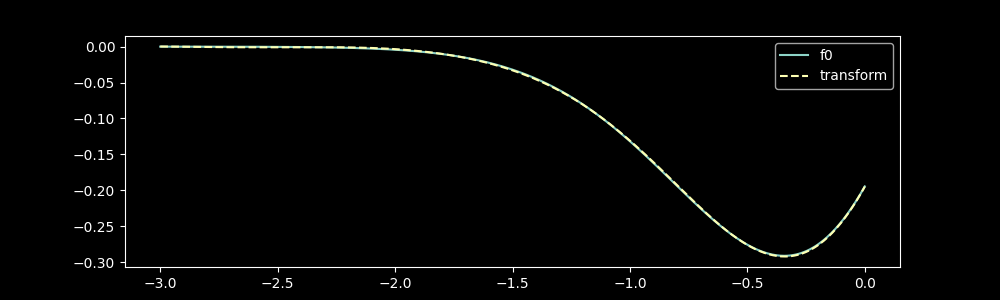

In [68]:
plt.close('all')
fig, ax = plt.subplots(figsize=(10,3))
ax.plot(xLs, f_input_1(xLs), label='f0');
ax.plot(xLs, f1s.real, '--', label='transform');
plt.legend();


### Second Region

We could just go ahead and do the same thing using Z2 as the variable.  This would give use the input function.  But I think the issue would then be the propagation in the z direction.  So I expect we will need to add that here too in order to see a difference.

### Adding z-direction

In [71]:
k1, k2 = A.Ks[:]

In [72]:
def f1(x, zs=1, F=F1, LZ1=-5, RZ1=5, N=50):
    x,zs = np.array(x), np.array(zs)
    s = np.zeros((len(zs), len(x)), dtype=complex)
    Z1s = np.linspace(LZ1, RZ1, N)
    dZ1 = Z1s[1] - Z1s[0]
    for Z1 in Z1s:
        y1 = F(Z1)*np.exp(-1j*Z1*x)
        beta = np.sqrt(k1**2 - Z1**2, dtype=complex)
        y2 = np.exp(1j*beta*zs)* dZ1
        s += np.outer(y2, y1) 
    return s


#### Note that the image below has no material differences between the two regions

This is just to get an idea of how the method works on a single region.  It does well!

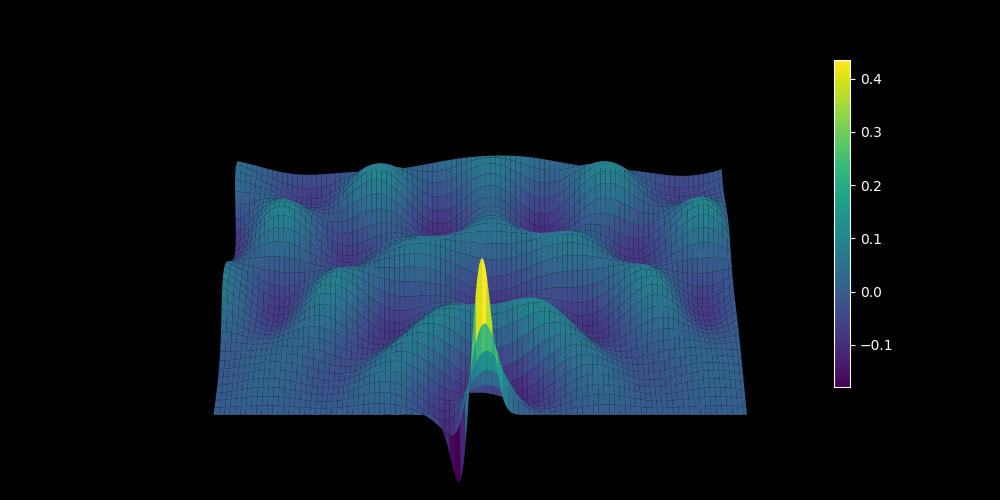

In [73]:
xs = np.linspace(-15,17, 300)
A.plot_field_2d(f1, xs=xs, surface=True, zmax=20, cstride=3, rstride=3, elev=50, azim=-90)

### Second region again

Okay, now we can do the integrals for the second region, but we also need to account for the relationships between Z1 and Z2 in the two regions.

In [50]:
# Here the transform is no different.  It doesn't know about other region.
# We'll try to put that information only in inverse transform and see what happens.

def F2(Z1, f=f_input_1, Lx=-3, Rx=3, N=17):
    # Z2 = np.sign(Z1) * np.sqrt(k2**2 - k1**2 + Z1**2, dtype=complex)
    xs = np.linspace(Lx, Rx, N)
    dx = xs[1] - xs[0]
    return 1/(2*np.pi)*sum([f(x)*np.exp(1j*Z1*x)*dx for x in xs])

F2 = np.vectorize(F2)


In [51]:
all_Zs = np.linspace(-25,25, 200)
F2ws = F2(all_Zs)

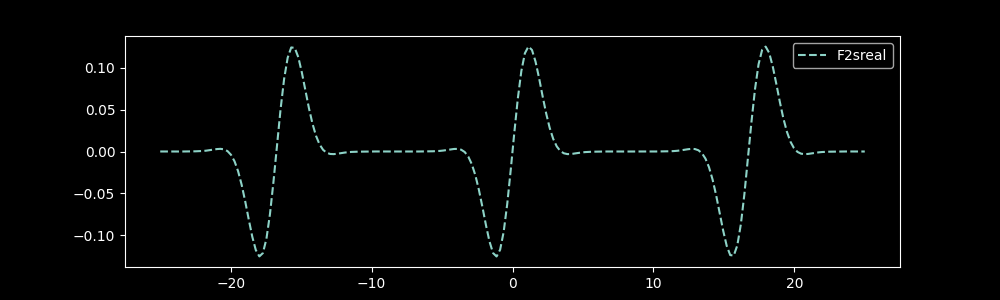

In [52]:
plt.close('all')
fig, ax = plt.subplots(figsize=(10,3))
# ax.plot(all_Zs, Fsci1s.imag, label='Fscis')
ax.plot(all_Zs, F2ws.imag, '--', label='F2sreal')

plt.legend();


Now for inverse transform with propagation and information relating Z1 and Z2... or wait, no it will just come in the beta part...

In [47]:
def f2(x, zs=0, F=F2, LZ2=-5, RZ2=5, N=13):
    x,zs = np.array(x), np.array(zs)
    s = np.zeros((len(zs), len(x)), dtype=complex)
    Z2s = np.linspace(LZ2, RZ2, N)
    dZ2 = Z2s[1] - Z2s[0]
    for Z2 in Z2s:
        y1 = F(Z2)*np.exp(-1j*Z2*x)
        beta = np.sqrt(k2**2 - Z2**2, dtype=complex)
        y2 = np.exp(1j*beta*zs)* dZ2
        s += np.outer(y2, y1) 
    return s
    

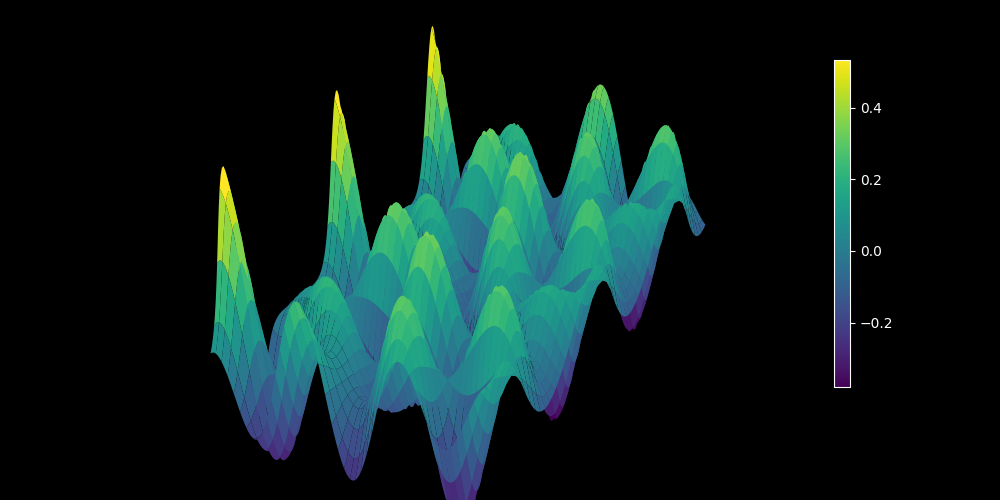

In [51]:
A.plot_field_2d(f2, xs=np.linspace(-10,10,200), surface=True, zmax=10, zref=200)

Now to see if they agree at interface

In [43]:
xLs = np.linspace(-15,0, 150)
xRs = np.linspace(0,15, 150)

In [44]:
zs = np.linspace(0, 10, 200)

In [45]:
XR, ZR = np.meshgrid(xRs, zs)
YRs = f2(xRs, zs)

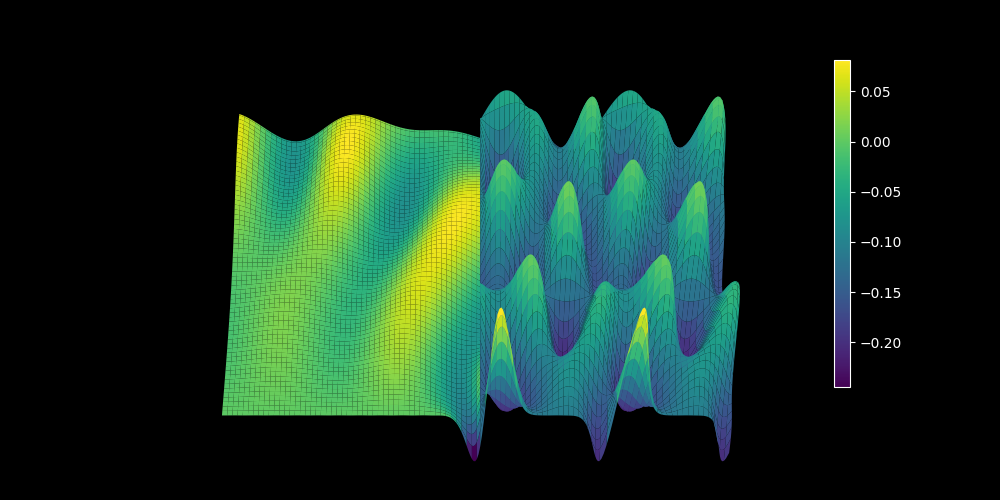

In [46]:
fig, ax = A.plot_field_2d(f1, xs=xLs, surface=True, zmax=10, zref=200, azim=-90, elev=60,
                cstride=3, rstride=3, return_fig_ax=True)

ax.plot_surface(XR, ZR, YRs.real, clip_on=False, cmap='viridis');

## They don't line up

Not just doing Fourier separately with accounting for different z-direction propagation only coming into play in the inverse transform.

##  What next?

Well we need to go back to integrating our fields that satisfy the interface conditions.  Let me get those field here as functions of Z1:

In [30]:
def T(Z1, rho=0, k1=1, k2=2):
    '''Transfer matrix at rho with left k=k1, right k=k2.'''
    Z2 = np.sqrt(k2**2-k1**2 + Z1**2, dtype=complex)
    a = -(Z1 + Z2) * np.exp(1j*Z1*rho) * np.exp(-1j*Z2*rho)
    b = (Z1 - Z2) * np.exp(1j*Z1*rho) * np.exp(1j*Z2*rho)
    return -1/(2*Z2)*np.array([[a, b.conjugate()], [b, a.conjugate()]])

def RadMode(Z1, A0=1, rho=0, k1=1, k2=2, phase_shift=0):
    Z2 = np.sqrt(k2**2-k1**2 + Z1**2, dtype=complex)
    C0 = np.array([A0, A0.conjugate()])
    C1 = T(Z1, rho, k1, k2) @ C0
    
    def F(x,zs=0):
        try:
            len(x)
            x = np.array(x)
        except TypeError:
            x = np.array([x])

        try:
            len(zs)
            zs = np.array(zs)
        except TypeError:
            zs = np.array([zs])
        x,zs = np.array(x), np.array(zs)
        f1 = lambda x: C0[0]*np.exp(1j*Z1*x)+C0[1]*np.exp(-1j*Z1*x)
        f2 = lambda x: C1[0]*np.exp(1j*Z2*x)+C1[1]*np.exp(-1j*Z2*x)
        conds = [(x<rho), (x>rho)]
        y1 = np.piecewise(x+0j, conds, [f1,f2], )
        beta = np.sqrt(k1**2 - Z1**2, dtype=complex)
        y2 = np.exp(1j*beta*zs)
        if len(zs)>1:
            return np.outer(y2, y1)
        else:
            return np.outer(y2, y1)[0]
    return F


In [32]:
Frad = RadMode(.4)
xs = np.linspace(-12,8, 300)


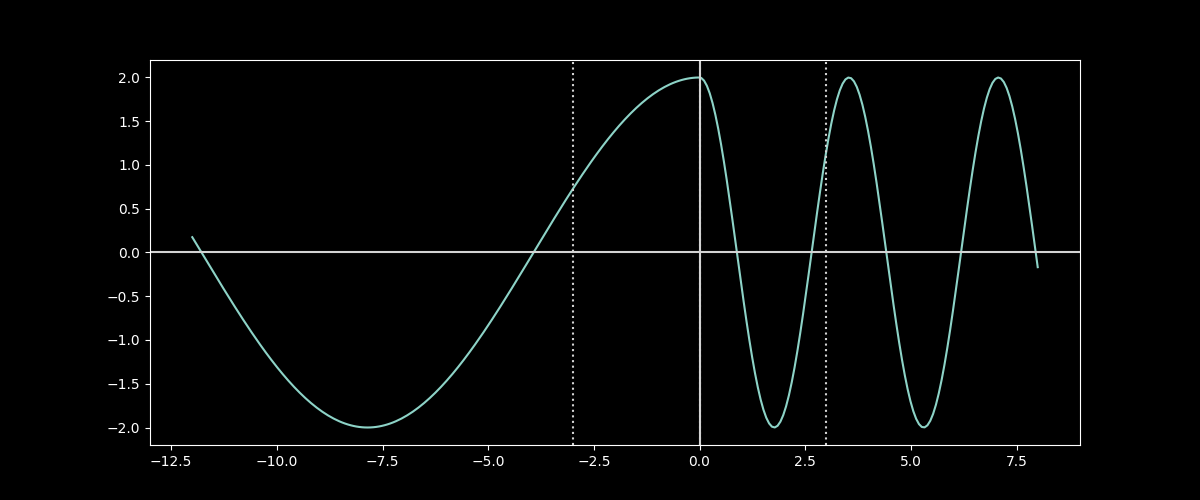

In [33]:
A.plot_field_1d(Frad, xs=xs)

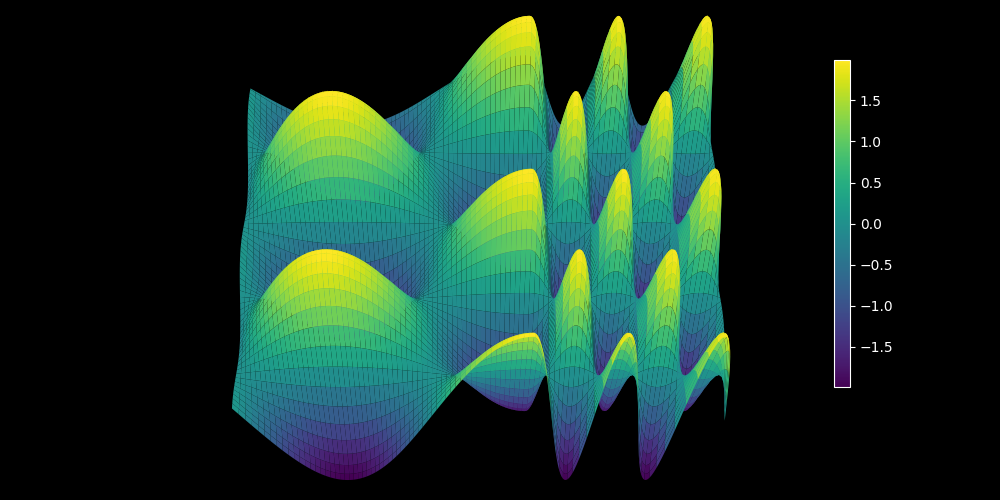

In [34]:
 A.plot_field_2d(Frad, xs=xs, surface=True, zmax=15, zref=200,elev=65, azim=-90,
                cstride=3, rstride=3)

Right, we can see right there that as Z1 is at zero, Z2 can't get to values less than k2^2-k1^2 here thats 3.

If we did it the other way... Field on other side would have this problem. (Wait, really?  Why?  Seems like it wouldn't, and if it didn't then we should integrate over Z parameter associeted with highest k)

Maybe this is part of the reason we also need guided modes, but I'm pretty sure this two layer structure doesn't have them..
Let's check quick:

In [35]:
from fiberamp.fiber.microstruct.bragg import plotlogf, plotlogf_real

In [151]:
# plotlogf(A.determinant, 0, 2, -1, 1, rref=200, iref=200, levels=100)

Right, this has no guided modes.  Let's check that other thing (parenthetical in above markdown cell)

Okay I did that and it was interesting but won't solve the problem.  However it does illuminate the fact that even integrating over beta, the Z_i s don't take on all possible values, each one bottoms out at sqrt(k_i^2 - k_low ^2).  So that means that integrating over Z with lowest k value will allow other Z_i s to go through same values as they would integrating over beta.

Okay, so now to integrate over Z1.


In [93]:
# Need to do transform first, now with rad modes

def F_rad(Z, f0, Lx=-10, Rx=10, N=90, A0=1, mode=None):
    xs = np.linspace(Lx, Rx, N)
    dx = xs[1] - xs[0]
    beta = np.sqrt(k2**2 - Z**2, dtype=complex)
    if mode is None:
        mode = RadMode(Z, A0=A0)
    return 1/(2*np.pi)*sum([f0(x)*mode(x)*dx for x in xs])

F_rad = np.vectorize(F_rad)

In [94]:
all_Zs = np.linspace(-5,5, 200)
Frads = F_rad(all_Zs, f_input_1)
F_stand = F1(all_Zs, f=f_input_1)

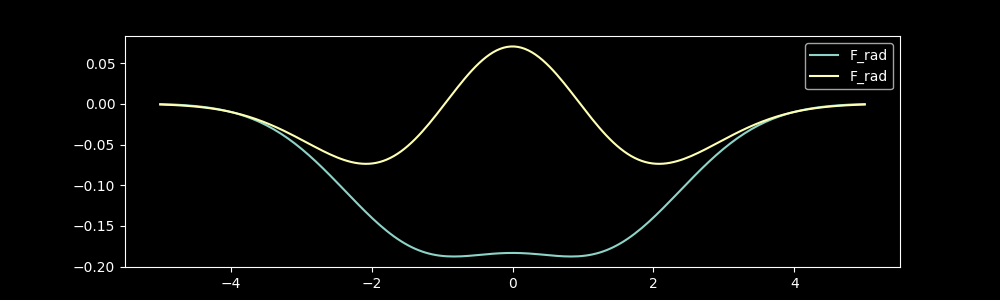

In [95]:
plt.close('all')
fig, ax = plt.subplots(figsize=(10,3))
ax.plot(all_Zs, Frads.real, label='F_rad')
ax.plot(all_Zs, F_stand.real, label='F_rad')

plt.legend();


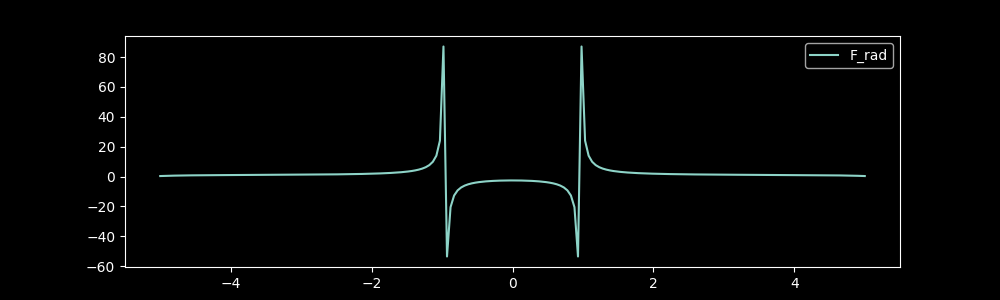

In [96]:
plt.close('all')
fig, ax = plt.subplots(figsize=(10,3))
ax.plot(all_Zs, Frads.real/F_stand.real, label='F_rad')

plt.legend();


In [97]:
A.Ks

array([1., 2.])

In [98]:
def f_rad(x, f0, zs=0, LZ=-100, RZ=100, N=200, A0=1):
    try:
        len(x)
        x = np.array(x)
    except TypeError:
        x = np.array([x])

    try:
        len(zs)
        zs = np.array(zs)
    except TypeError:
        zs = np.array([zs])
        
    s = np.zeros((len(zs), len(x)), dtype=complex)
    Zs = np.linspace(LZ, RZ, N)
    dZ = Zs[1] - Zs[0]
    modes = np.array([RadMode(Z, A0=A0) for Z in Zs])
    for mode, Z in zip(modes, Zs):
        y1 = F_rad(Z, f0, mode=mode, A0=A0)*mode(x)
        beta = np.sqrt(k2**2 - Z**2, dtype=complex)
        y2 = np.exp(1j*beta*zs)* dZ
        s += np.outer(y2, y1) 
    if len(zs)>1:
        return s
    else:
        return s[0]
    

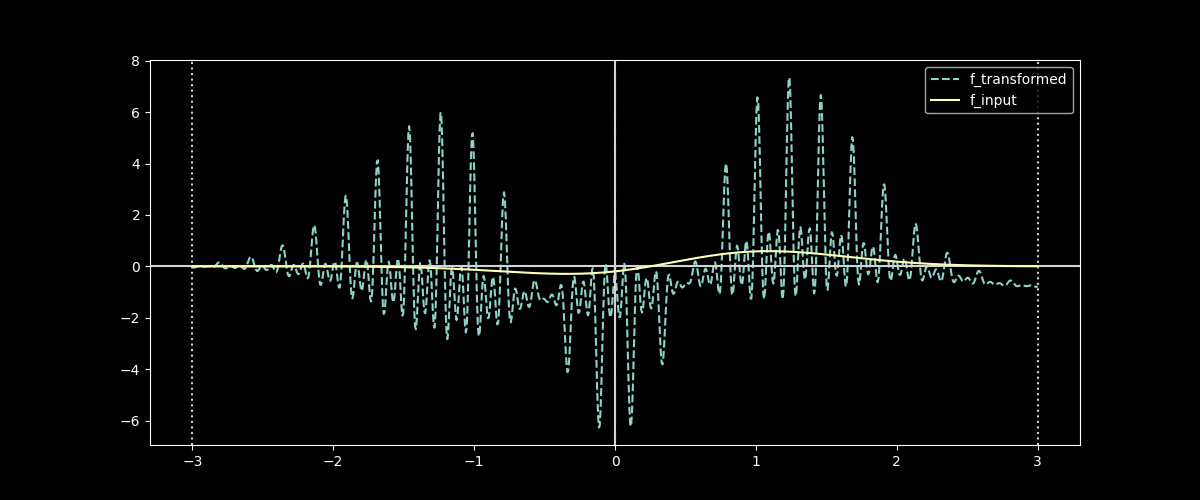

In [99]:
fig, ax = A.plot_field_1d(f_rad, f_input_1, label='f_transformed',  linestyle='--', return_fig_ax=True)
A.add_1d_plot(ax, f_input_1, label='f_input')
plt.legend();

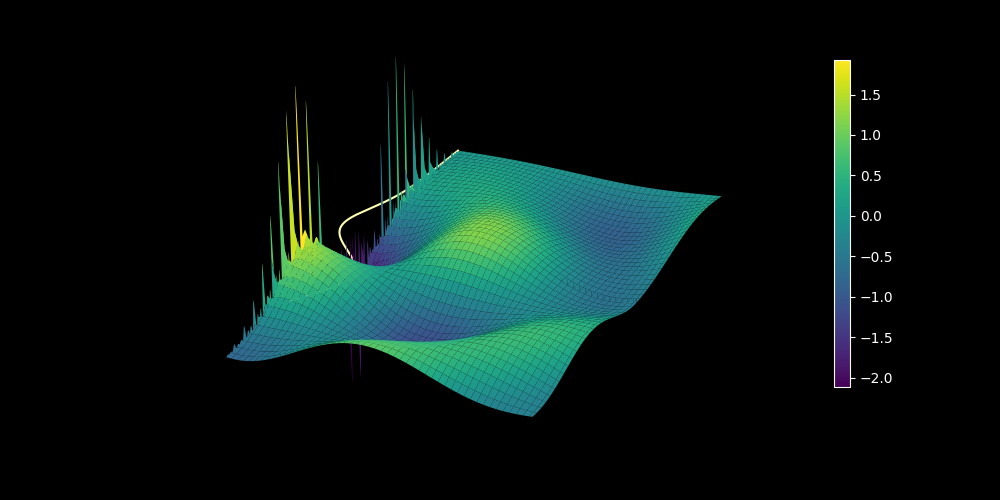

In [104]:
fig, ax = A.plot_field_2d(f_rad, f_input_1, surface=True, return_fig_ax=True)
A.add_1d_plot(ax, f_input_1)

## Conclusions

Still can't handle the two region thing.  Jay says doing 3 is more likely to give correct results (so long as first and last region have same refractive index), so I'll try that in the next notebook: Three Region Fourier